In [98]:
import pandas as pd
import numpy as np

In [99]:
track_anr ={'iPWR':0, 'HTGR':0, 'PBR-HTGR':0, 'iMSR':0, 'Micro':0}
markers = {'iPWR':'p', 'HTGR':'v', 'PBR-HTGR':'X', 'iMSR':'o', 'Micro':'s'}

In [100]:
def update_capex_costs(ANR_data, FOAK_ANR_data, learning_rate_anr_capex, ANR_type, N):
  foak_capex = FOAK_ANR_data.loc[ANR_type, 'CAPEX $/MWe']
  ANR_data['CAPEX $/MWe'] = ANR_data['CAPEX $/MWe'].astype(float)
  ANR_data.loc[ANR_type, 'CAPEX $/MWe'] = foak_capex*np.power(N, np.log2(1-learning_rate_anr_capex))
  return ANR_data

In [101]:
H2_data = pd.read_excel('./h2_tech.xlsx', sheet_name='Summary', index_col=[0,1])

In [102]:
learning_rate_anr_capex = 0.07

In [103]:
clean_results = './results/clean_results_anr_lr_0_h2_lr_0_wacc_0.077.xlsx'

# Steel

In [104]:
from opt_deployment_steel import solve_steel_plant_deployment

In [105]:
steel_res_foak = pd.read_excel(clean_results, sheet_name='steel')
steel_res_foak.sort_values(by=['Breakeven price ($/MMBtu)']) # solve deployment in order of decreasing profitability
steel_res_foak.head(3)
steel_ids = steel_res_foak['id'].to_list()

In [106]:
FOAK_ANR_data = pd.read_excel('./ANRs.xlsx', sheet_name='FOAK', index_col=0)
current_ANR_data = FOAK_ANR_data.copy()

In [107]:
steel_results = {}

for id in steel_ids: 
  result_id = solve_steel_plant_deployment(ANR_data=current_ANR_data, H2_data=H2_data, plant=id)
  steel_results[id] = result_id
  ANR_type = result_id['ANR type']
  track_anr[ANR_type] += result_id['# ANR modules']
  print(f"Solved plant {id}, {result_id['# ANR modules']} modules of type {ANR_type}")
  print(f'Updating ANR capex costs accounting for learning, total {track_anr[ANR_type]} of {ANR_type} deployed')
  current_ANR_data = update_capex_costs(current_ANR_data, FOAK_ANR_data, learning_rate_anr_capex, ANR_type, track_anr[ANR_type])
ANR_data_post_steel = current_ANR_data

Start Cleveland-Cliffs Indiana Harbor steel plant
Solved Cleveland-Cliffs Indiana Harbor steel plant
Solved plant Cleveland-Cliffs Indiana Harbor steel plant, 9 modules of type iMSR
Updating ANR capex costs accounting for learning, total 9 of iMSR deployed
Start Cleveland-Cliffs Cleveland steel plant


Solved Cleveland-Cliffs Cleveland steel plant
Solved plant Cleveland-Cliffs Cleveland steel plant, 5 modules of type iMSR
Updating ANR capex costs accounting for learning, total 14 of iMSR deployed
Start U.S. Steel Gary Works
Solved U.S. Steel Gary Works
Solved plant U.S. Steel Gary Works, 12 modules of type iMSR
Updating ANR capex costs accounting for learning, total 26 of iMSR deployed
Start Cleveland-Cliffs Middletown steel plant
Solved Cleveland-Cliffs Middletown steel plant
Solved plant Cleveland-Cliffs Middletown steel plant, 4 modules of type iMSR
Updating ANR capex costs accounting for learning, total 30 of iMSR deployed
Start Cleveland-Cliffs Riverdale steel plant
Solved Cleveland-Cliffs Riverdale steel plant
Solved plant Cleveland-Cliffs Riverdale steel plant, 2 modules of type iMSR
Updating ANR capex costs accounting for learning, total 32 of iMSR deployed
Start U.S. Steel Edgar Thomson Plant
Solved U.S. Steel Edgar Thomson Plant
Solved plant U.S. Steel Edgar Thomson Plant, 

In [108]:
# Merge FOAK results and deployment with learning
steel_results_df = pd.DataFrame(steel_results).transpose()
steel_results_df['Learning'] = 'With'
steel_results_df['Cumulative # ANR modules'] = steel_results_df['# ANR modules'].cumsum()

steel_res_foak['Cumulative # ANR modules'] = steel_res_foak['# ANR modules'].cumsum()
steel_res_foak['Learning'] = 'Without'

steel_plot_df = pd.concat([steel_results_df, steel_res_foak], axis=0, ignore_index=True)

(-0.3, 5.0)

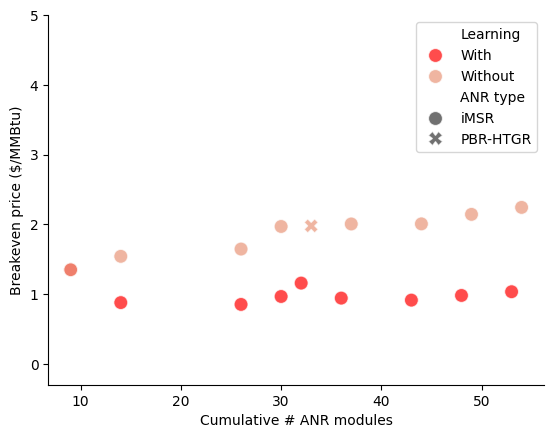

In [109]:
# Plot
import seaborn as sns
ax = sns.scatterplot(data=steel_plot_df, x='Cumulative # ANR modules', y='Breakeven price ($/MMBtu)', palette=['red', 'darksalmon'], style='ANR type', hue='Learning', markers=markers, s=100, alpha=0.7)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-.3,5)

# Refining

In [110]:
from opt_deployment_refining import solve_refinery_deployment

In [111]:
refining_res_foak = pd.read_excel(clean_results, sheet_name='refining')
refining_res_foak.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
refining_res_foak.head(3)

,id,state,H2 Dem. (kg/day),Net Revenues ($/year),Alkaline,HTSE,PEM,Ann. CO2 emissions (kgCO2eq/year),ANR CAPEX ($/year),H2 CAPEX ($/year),...,Breakeven price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum h2 dem (t/day),Viable ANR modules count,Viable ANR refineries count,Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year)
0,CH_PAS,MISSISSIPPI,296403.233462,-1.484734e+08,0,297.0,0,2.785506e+07,6.971323e+07,1.194230e+07,...,9.072257,300,iMSR,600,0.6,296.403233,2,1,1.258274,1.258274
1,Fl_SAI,MINNESOTA,288453.321893,-1.477628e+08,0,289.0,0,2.710475e+07,6.971323e+07,1.162062e+07,...,9.277675,300,iMSR,600,1.2,584.856555,4,2,1.224529,2.482803
2,WR_WOO,ILLINOIS,275407.694269,-1.412252e+08,0,276.0,0,2.495128e+07,6.626269e+07,1.069737e+07,...,9.287221,200,PBR-HTGR,600,1.8,860.264250,7,3,1.170076,3.652879


In [112]:
refining_ids = refining_res_foak['id'].to_list()

In [113]:
current_ANR_data = ANR_data_post_steel.copy()
refining_results = {}
for id in refining_ids: 
  result_id = solve_refinery_deployment(ANR_data=current_ANR_data, H2_data=H2_data, ref_id=id)
  refining_results[id] = result_id
  ANR_type = result_id['ANR type']
  track_anr[ANR_type] += result_id['# ANR modules']
  print(f"Solved plant {id}, {result_id['# ANR modules']} modules of type {ANR_type}")
  print(f'Updating ANR capex costs accounting for learning, total {track_anr[ANR_type]} of {ANR_type} deployed')
  current_ANR_data = update_capex_costs(current_ANR_data, FOAK_ANR_data, learning_rate_anr_capex, ANR_type, track_anr[ANR_type])
  
ANR_data_post_refining = current_ANR_data

Start solve for CH_PAS


Refining plant CH_PAS solved
Solved plant CH_PAS, 2 modules of type iMSR
Updating ANR capex costs accounting for learning, total 55 of iMSR deployed
Start solve for Fl_SAI
Refining plant Fl_SAI solved
Solved plant Fl_SAI, 2 modules of type iMSR
Updating ANR capex costs accounting for learning, total 57 of iMSR deployed
Start solve for WR_WOO
Refining plant WR_WOO solved
Solved plant WR_WOO, 2 modules of type iMSR
Updating ANR capex costs accounting for learning, total 59 of iMSR deployed
Start solve for VA_BEN
Refining plant VA_BEN solved
Solved plant VA_BEN, 1 modules of type PBR-HTGR
Updating ANR capex costs accounting for learning, total 1 of PBR-HTGR deployed
Start solve for VA_NOR
Refining plant VA_NOR solved
Solved plant VA_NOR, 1 modules of type iMSR
Updating ANR capex costs accounting for learning, total 60 of iMSR deployed
Start solve for HO_EL 
Refining plant HO_EL  solved
Solved plant HO_EL , 1 modules of type PBR-HTGR
Updating ANR capex costs accounting for learning, total 

In [114]:
# Merge FOAK results and deployment with learning
refining_results_df = pd.DataFrame(refining_results).transpose()
refining_results_df['Learning'] = 'With'
refining_results_df['Cumulative # ANR modules'] = refining_results_df['# ANR modules'].cumsum()

refining_res_foak['Cumulative # ANR modules'] = refining_res_foak['# ANR modules'].cumsum()
refining_res_foak['Learning'] = 'Without'

refining_plot_df = pd.concat([refining_results_df, refining_res_foak], axis=0, ignore_index=True)

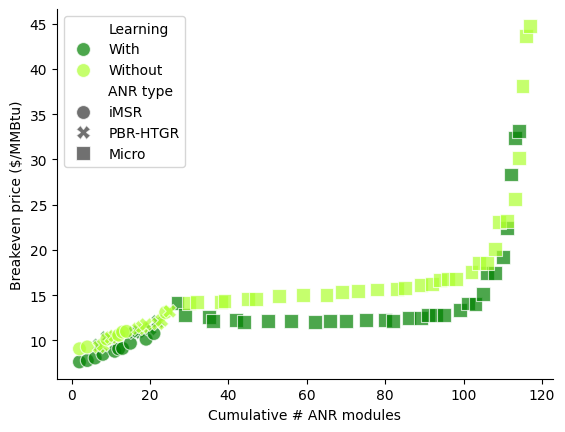

In [115]:
# Plot
import seaborn as sns
ax = sns.scatterplot(data=refining_plot_df, x='Cumulative # ANR modules', y='Breakeven price ($/MMBtu)', palette=['green', 'greenyellow'], style='ANR type', hue='Learning', markers=markers, s=100, alpha=0.7)
ax.spines[['right', 'top']].set_visible(False)


# Process heat

In [116]:
from opt_deployment_heat_process import solve_process_heat_deployment

In [117]:
heat_res_foak = pd.read_excel(clean_results, sheet_name='process_heat')
heat_res_foak.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)


In [118]:
heat_ids = heat_res_foak['id'].to_list()


In [119]:
current_ANR_data = ANR_data_post_refining.copy()
heat_results = {}
for id in heat_ids: 
  result_id = solve_process_heat_deployment(ANR_data=current_ANR_data, H2_data=H2_data, plant_id=id)
  heat_results[id] = result_id
  ANR_type = result_id['ANR type']
  track_anr[ANR_type] += result_id['# ANR modules']
  print(f"Solved plant {id}, {result_id['# ANR modules']} modules of type {ANR_type}")
  print(f'Updating ANR capex costs accounting for learning, total {track_anr[ANR_type]} of {ANR_type} deployed')
  current_ANR_data = update_capex_costs(current_ANR_data, FOAK_ANR_data, learning_rate_anr_capex, ANR_type, track_anr[ANR_type])
  
ANR_data_post_heat = current_ANR_data

Start solve for 1000588
Process heat for plant 1000588 solved
Solved plant 1000588, 1 modules of type iMSR
Updating ANR capex costs accounting for learning, total 69 of iMSR deployed
Start solve for 1007177
Process heat for plant 1007177 solved
Solved plant 1007177, 1 modules of type iMSR
Updating ANR capex costs accounting for learning, total 70 of iMSR deployed
Start solve for 1000418
Process heat for plant 1000418 solved
Solved plant 1000418, 3 modules of type iMSR
Updating ANR capex costs accounting for learning, total 73 of iMSR deployed
Start solve for 1005198
Process heat for plant 1005198 solved
Solved plant 1005198, 1 modules of type iMSR
Updating ANR capex costs accounting for learning, total 74 of iMSR deployed
Start solve for 1000630
Process heat for plant 1000630 solved
Solved plant 1000630, 2 modules of type PBR-HTGR
Updating ANR capex costs accounting for learning, total 9 of PBR-HTGR deployed
Start solve for 1005491
Process heat for plant 1005491 solved
Solved plant 100

In [120]:
# Merge FOAK results and deployment with learning
heat_results_df = pd.DataFrame(heat_results).transpose()
heat_results_df['Learning'] = 'With'
heat_results_df['Cumulative # ANR modules'] = heat_results_df['# ANR modules'].cumsum()

heat_res_foak['Cumulative # ANR modules'] = heat_res_foak['# ANR modules'].cumsum()
heat_res_foak['Learning'] = 'Without'

heat_plot_df = pd.concat([heat_results_df, heat_res_foak], axis=0, ignore_index=True)

(0.0, 50.0)

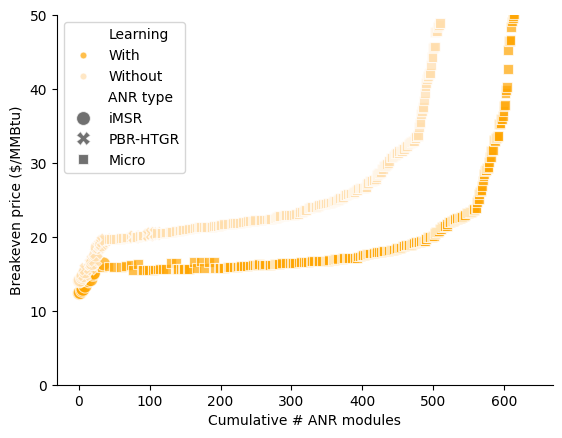

In [121]:
# Plot
import seaborn as sns
ax = sns.scatterplot(data=heat_plot_df, x='Cumulative # ANR modules', y='Breakeven price ($/MMBtu)', palette=['orange', 'navajowhite'], style='ANR type', hue='Learning', marker='.', s=100, alpha=0.7)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(0,50)


# Ammonia

In [122]:
from opt_deployment_ammonia import solve_ammonia_plant_deployment

In [123]:
# Read ammonia results 
a_res = pd.read_excel(clean_results, sheet_name='ammonia')
a_res.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
a_res.head(3)

,id,state,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),PEM,Alkaline,HTSE,Ann. CO2 emissions (kgCO2eq/year),...,Viable ANR ammonia plants count,Plant,City,State,Capacity (tNH3/year),H2 Dem. (kg/year),Electricity demand (MWe),NG path GHG (tCO2/year),Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year)
0,CF_Do,LA,3935000,5.441214e+06,2.227288,-2.624499e+09,0,0,5442,5.103946e+08,...,1,CF Industries Inc.,Donaldsonville,LA,3935000,1.986043e+09,53.454909,9050500.0,8.540105,8.540105
1,Ko_En,OK,1015000,1.403515e+06,0.574510,-6.786232e+08,0,0,1404,1.316784e+08,...,2,Koch Industries Inc.,Enid,OK,1015000,5.122830e+08,13.788242,2334500.0,2.202822,10.742927
2,LS_El,AK,445000,6.153342e+05,0.251879,-3.033982e+08,0,0,616,5.777345e+07,...,3,LSB Industries,El Dorado,AK,445000,2.245970e+08,6.045091,1023500.0,0.965727,11.708653


In [124]:
# List of ids in order of increasing breakeven price
ammonia_ids = a_res['id'].to_list()


In [125]:
current_ANR_data = ANR_data_post_heat.copy()
ammonia_results = {}
for id in ammonia_ids: 
  result_id = solve_ammonia_plant_deployment(ANR_data=current_ANR_data, H2_data=H2_data, plant=id, print_results=False)
  ammonia_results[id] = result_id
  ANR_type = result_id['ANR type']
  track_anr[ANR_type] += result_id['# ANR modules']
  print(f"Solved plant {id}, {result_id['# ANR modules']} modules of type {ANR_type}")
  print(f'Updating ANR capex costs accounting for learning, total {track_anr[ANR_type]} of {ANR_type} deployed')
  current_ANR_data = update_capex_costs(current_ANR_data, FOAK_ANR_data, learning_rate_anr_capex, ANR_type, track_anr[ANR_type])
  


Ammonia plant CF_Do : start solving


Ammonia plant CF_Do solved
Solved plant CF_Do, 35 modules of type iMSR
Updating ANR capex costs accounting for learning, total 120 of iMSR deployed
Ammonia plant Ko_En : start solving
Ammonia plant Ko_En solved
Solved plant Ko_En, 9 modules of type iMSR
Updating ANR capex costs accounting for learning, total 129 of iMSR deployed
Ammonia plant LS_El : start solving
Ammonia plant LS_El solved
Solved plant LS_El, 4 modules of type iMSR
Updating ANR capex costs accounting for learning, total 133 of iMSR deployed
Ammonia plant CF_Ve : start solving
Ammonia plant CF_Ve solved
Solved plant CF_Ve, 10 modules of type iMSR
Updating ANR capex costs accounting for learning, total 143 of iMSR deployed
Ammonia plant LS_Pr : start solving
Ammonia plant LS_Pr solved
Solved plant LS_Pr, 2 modules of type iMSR
Updating ANR capex costs accounting for learning, total 145 of iMSR deployed
Ammonia plant Nu_Au : start solving
Ammonia plant Nu_Au solved
Solved plant Nu_Au, 7 modules of type iMSR
Updating ANR 

In [126]:
ammonia_results_df = pd.DataFrame(ammonia_results).transpose()
ammonia_results_df['Learning'] = 'With'
ammonia_results_df['Cumulative # ANR modules'] = ammonia_results_df['# ANR modules'].cumsum()

previous_be = a_res.copy()
previous_be['Cumulative # ANR modules'] = previous_be['# ANR modules'].cumsum()
previous_be['Learning'] = 'Without'

to_plot_df = pd.concat([ammonia_results_df, previous_be], axis=0, ignore_index=True)

to_plot_df

,id,state,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),PEM,Alkaline,HTSE,Ann. CO2 emissions (kgCO2eq/year),...,Viable ANR ammonia plants count,Plant,City,State,Capacity (tNH3/year),H2 Dem. (kg/year),Electricity demand (MWe),NG path GHG (tCO2/year),Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year)
0,CF_Do,LA,3935000.0,5441214.013274,2.227288,-2170728352.121812,0,0,5442.0,510394644.288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ko_En,OK,1015000.0,1403515.177503,0.57451,-554952731.768871,0,0,1404.0,131678441.856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LS_El,AK,445000.0,615334.240383,0.251879,-247796407.334883,0,0,616.0,57773447.424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CF_Ve,OK,1100000.0,1521050.931284,0.622622,-610477344.857284,0,0,1522.0,142745433.408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LS_Pr,OK,225000.0,311124.054126,0.127354,-126052446.923855,0,0,312.0,29261875.968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,U._Mo,TN,60000,82966.414434,0.033961,-50801726.402694,0,0,83,7503465.6,...,30.0,U.S. Nitrogen LLC.,Mosheim,TN,60000.0,3.028274e+07,0.815068,138000.0,0.130497,38.837948
64,Ne_Ge,NE,90000,124449.62165,0.050942,-76646513.36736,0,0,125,11723508.0,...,31.0,Nebraska Nitrogen,Geneva,NE,90000.0,4.542411e+07,1.222603,207000.0,0.195276,39.033225
65,Gr_Cr,IA,32000,44248.754365,0.018113,-38617394.042005,0,0,45,3386020.32,...,32.0,Green Valley Chemical,Creston,IA,32000.0,1.615080e+07,0.434703,73600.0,0.070214,39.103439
66,Ch_El,CA,25000,34569.339347,0.01415,-31722100.857303,0,0,35,2633571.36,...,33.0,Chevron Chem. Co.,El Segundo,CA,25000.0,1.261781e+07,0.339612,57500.0,0.054866,39.158305


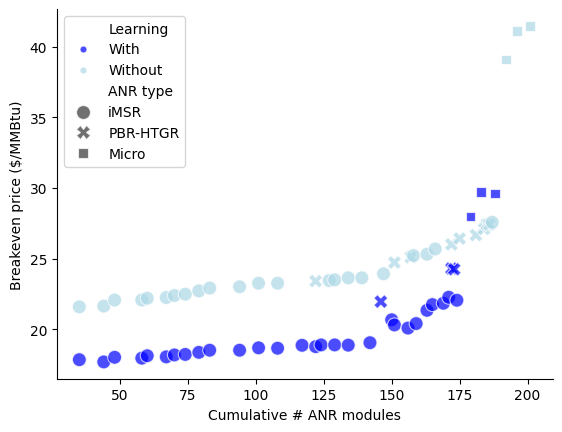

In [127]:
import seaborn as sns
ax = sns.scatterplot(data=to_plot_df, x='Cumulative # ANR modules', y='Breakeven price ($/MMBtu)', palette=['blue', 'lightblue'], style='ANR type', hue='Learning', marker='.', s=100, alpha=0.7)
ax.spines[['right', 'top']].set_visible(False)


#

# Compute avoided emissions

In [129]:
# Ammonia
ammonia_demand_df = pd.read_excel('./h2_demand_ammonia_us_2022.xlsx', sheet_name='processed')
ammonia_results_df = ammonia_results_df.merge(ammonia_demand_df, on='id')
ratio_co2_to_nh3 = 2.30 # tCO2eq/tNH3
ammonia_results_df['NG path GHG (tCO2/year)'] = ammonia_results_df.apply(lambda x:x['Capacity (tNH3/year)']*2.30, axis=1)

ammonia_results_df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (ammonia_results_df['NG path GHG (tCO2/year)'] \
                                                   - (ammonia_results_df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6

In [131]:
# Process heat
demand_heat_df = pd.read_excel('./h2_demand_industry_heat.xlsx', sheet_name='max')
demand_heat_df = demand_heat_df[['FACILITY_ID', 'MMTCO2E']]
heat_results_df = heat_results_df.merge(demand_heat_df, left_on='id', right_on='FACILITY_ID')
heat_results_df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = heat_results_df.apply(lambda row: row['MMTCO2E']- row['Ann. CO2 emissions (kgCO2eq/year)']/1e9, axis=1)

In [132]:
# Refining
SMR_carbon_intensity = 11.888 #kgCO2eq/kgH2
refining_results_df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (refining_results_df['H2 Dem. (kg/day)']*365*SMR_carbon_intensity - refining_results_df['Ann. CO2 emissions (kgCO2eq/year)'])/1e9

In [133]:
# Steel
demand_steel_df = pd.read_excel('./h2_demand_bfbof_steel_us_2022.xlsx', sheet_name='processed')
steel_results_df = steel_results_df.merge(demand_steel_df, left_on='id', right_on='Plant')
steel_results_df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (steel_results_df['GHG QUANTITY (METRIC TONS CO2e)'] - (steel_results_df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6

# Save results of each sector with learning

In [134]:
dict_to_save ={'ammonia':ammonia_results_df, 'process_heat':heat_results_df, 'refining':refining_results_df, 'steel':steel_results_df}
excel_file = './results/raw_results_with_learning.xlsx'
for sheet_name, df in dict_to_save.items():
  try:
  # Load the existing Excel file
    with pd.ExcelFile(excel_file, engine='openpyxl') as xls:
        # Check if the sheet exists
        if sheet_name in xls.sheet_names:
            # If the sheet exists, replace the data
            with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
                df.to_excel(writer, sheet_name=sheet_name, index=False)
        else:
            # If the sheet doesn't exist, create a new sheet
            with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
                df.to_excel(writer, sheet_name=sheet_name, index=False)
  except FileNotFoundError:
      # If the file doesn't exist, create a new one and write the DataFrame to it
      df.to_excel(excel_file, sheet_name=sheet_name, index=False)